<a href="https://colab.research.google.com/github/jayaydv12-stack/ds_jaya/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


In [19]:
trades = pd.read_csv("/content/historical_data.csv")
sentiment = pd.read_csv("/content/fear_greed_index.csv")

print(trades.shape)
print(sentiment.shape)

trades.head()

(211224, 16)
(2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [20]:
print(trades.columns)
print(sentiment.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [21]:
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['Timestamp'].dt.date

In [22]:
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='ms')
sentiment['date'] = sentiment['timestamp'].dt.date

In [23]:
# converting numeric timestamp
sentiment['timestamp'] = pd.to_numeric(sentiment['timestamp'], errors='coerce')
# detecting scale and normalize to seconds
sentiment.loc[sentiment['timestamp'] > 1e12, 'timestamp'] /= 1000   # ms → sec
sentiment.loc[sentiment['timestamp'] > 1e10, 'timestamp'] /= 1000   # µs → sec
# converting to datetime
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='s')
sentiment['date'] = sentiment['timestamp'].dt.date

In [24]:
sentiment['classification'] = sentiment['classification'].str.strip().str.capitalize()

sentiment['sentiment_flag'] = sentiment['classification'].map({
    'Fear': 0,
    'Greed': 1
})

sentiment = sentiment.dropna(subset=['sentiment_flag'])

In [25]:
print(sentiment[['timestamp','date','classification','sentiment_flag']].head())
print(sentiment['date'].nunique(), "unique sentiment days")

            timestamp        date classification  sentiment_flag
0 2018-02-01 05:30:00  2018-02-01           Fear             0.0
2 2018-02-03 05:30:00  2018-02-03           Fear             0.0
6 2018-02-07 05:30:00  2018-02-07           Fear             0.0
7 2018-02-08 05:30:00  2018-02-08           Fear             0.0
8 2018-02-09 05:30:00  2018-02-09           Fear             0.0
1414 unique sentiment days


In [26]:
# converting trades timestamp
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'])
trades['date'] = trades['Timestamp'].dt.date

print(trades[['Timestamp', 'date', 'Closed PnL']].head())
print("Trade days:", trades['date'].nunique())

            Timestamp        date  Closed PnL
0 2024-10-27 03:33:20  2024-10-27         0.0
1 2024-10-27 03:33:20  2024-10-27         0.0
2 2024-10-27 03:33:20  2024-10-27         0.0
3 2024-10-27 03:33:20  2024-10-27         0.0
4 2024-10-27 03:33:20  2024-10-27         0.0
Trade days: 7


In [27]:
merged = trades.merge(
    sentiment[['date', 'sentiment_flag']],
    on='date',
    how='left'
)

print(merged[['date', 'Closed PnL', 'sentiment_flag']].head())
print("Missing sentiment rows:", merged['sentiment_flag'].isna().sum())

         date  Closed PnL  sentiment_flag
0  2024-10-27         0.0             1.0
1  2024-10-27         0.0             1.0
2  2024-10-27         0.0             1.0
3  2024-10-27         0.0             1.0
4  2024-10-27         0.0             1.0
Missing sentiment rows: 41064


In [28]:
analysis = (
    merged
    .dropna(subset=['sentiment_flag'])
    .groupby('sentiment_flag')['Closed PnL']
    .agg(['count', 'mean', 'sum'])
)

analysis.index = analysis.index.map({0: 'Fear', 1: 'Greed'})
analysis

,count,mean,sum
sentiment_flag,,,
Fear,133871,50.047622,6.699925e+06
Greed,36289,87.894859,3.189617e+06


<Axes: title={'center': 'Average PnL: Fear vs Greed'}, xlabel='sentiment_flag'>

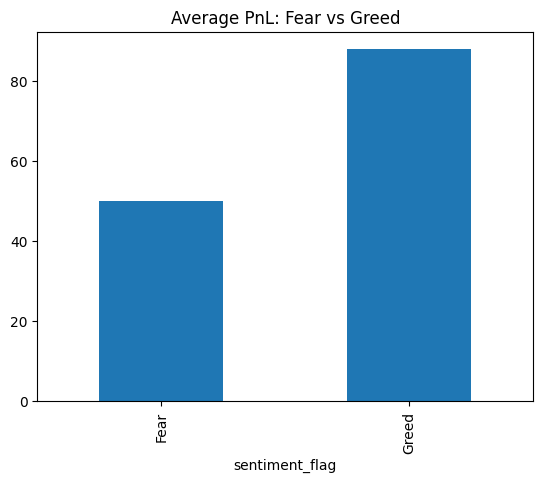

In [29]:
analysis[['mean']].plot(
    kind='bar',
    title='Average PnL: Fear vs Greed',
    legend=False
)